In [1]:
import dill
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

In [2]:
def sim_ambulance_overdoses(random=1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, n_a=1000, n_T=12):
    '''
    Simulate overdoses data, ambulance-call outs survey data and related variables 
    -----------
    mu_z- float 
        log rate for lambda
    
    sigma_z -float
        variance of log lambda
    
    N - int
        Total size of population
        
    p_a - float
        probability of calling ambulance at the scene of overdose
    
    n_a - int
        total number of survey
    
    n_T - int
        number of time points  
    '''
    #set.seed(1)
    np.random.seed(random)
    
    # generate z_t values
    zt = np.random.normal(loc=mu_z, scale = sigma_z, size = n_T)
    
    # convert into lambda_t
    lmd_t = np.exp(zt)
    
    # generate O_t data set
    o_t = np.random.poisson(lmd_t*N)
    
    # generate U_t data set
    u_t = np.random.binomial(n=o_t, p=p_a)
    
    # generate x_t data set
    x_a = np.random.binomial(n=n_a, p=p_a, size =12)
    
    return {'o_t':o_t, 'u_t':u_t, 'x_a':x_a, 'n_a':n_a,'N':N}

In [3]:
data= sim_ambulance_overdoses()

In [4]:
def create_model_N(data):
    
    
    with pm.Model() as model:
        # priors 
        p_a = pm.Beta('p_a', alpha=1, beta=1)
        # note that this prior is to be changed later
        mu_z = pm.Uniform('mu_z', -10, 0)
        sigma_z = pm.Uniform('sigma_z',0,5)
        
        # uncertain N
        N = pm.DiscreteUniform('N',lower=1,upper=2*10000)
        
        # latent variables
        z_t = pm.Normal('z_t', mu=mu_z, sigma=sigma_z, shape=(12,))
        lmb_t = pm.Deterministic('lmb_t', tt.exp(z_t))
#       o_t = pm.Poisson('o_t', lmb_t*N)
        o_t = pm.Gamma('o_t', mu=lmb_t*N , sigma=tt.sqrt(lmb_t*N), shape=(12,) )
        # MCMC with discrete random variable is hard to do sampling...
        # We approximate this to Gamma dist
        
        
        #likelihood 
        pm.Poisson('u_t', o_t*p_a, observed=data['u_t'])
        pm.Binomial('x_a', n=data['n_a'], p =p_a, observed=data['x_a'])
        
    return model

        

In [5]:
model_N = create_model_N(data)

In [6]:
with model_N:
    trace_N = pm.sample(1000, chains=2, random_seed=1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
>Metropolis: [N]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:16<00:00, 181.51draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
with model_N:
    trace = pm.sample(1000, chains=2, random_seed=1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
>Metropolis: [N]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 206.07draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


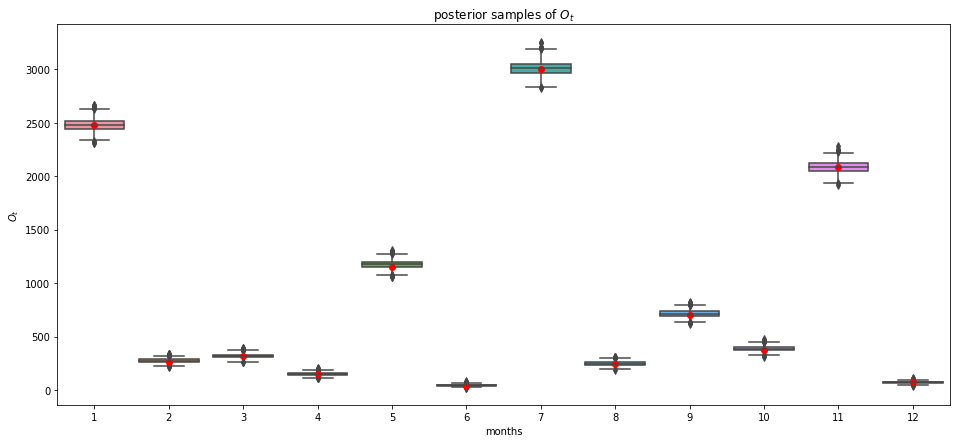

In [10]:
a4_dims = (16,7)
fig, ax = plt.subplots(figsize=a4_dims)
df = pd.DataFrame(data=trace['o_t'], columns=range(1,13))
ax=sns.boxplot(data=df)
plt.title("posterior samples of $O_t$")
ax.set_xlabel('months')
ax.set_ylabel('$O_t$')
ax2 = plt.plot(range(0,12), data['o_t'],'ro')
fig.savefig('../latex/Figures/earlyresult1_ot.png')

In [11]:
trace['N']

array([12020, 11990, 11990, ...,  8731,  8768,  8834])